In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import gzip
import random
import time
import matplotlib.pyplot as plt

def readGz(f):
    for l in gzip.open(f):
        yield eval(l)
print('ok')

ok


In [2]:
cnt=0
for l in readGz("data/train.json.gz"):
    print(l)
    cnt+=1
    if cnt>=5:
        break

{'rating': 5.0, 'businessID': 'B408037852', 'reviewText': "This is where i go to shop for gifts from my mom. She loves this stuff. Cna't get enough. I like that you can customize the items. Store is well alid out and shoppable.", 'userID': 'U093387342', 'reviewTime': 'Mar 24, 2013', 'categories': ["Women's Clothing Store", 'Fashion Accessories Store', 'Shoe Store'], 'reviewHash': 'R471510664', 'unixReviewTime': 1364143460}
{'rating': 5.0, 'businessID': 'B410583770', 'reviewText': "Quaint, stylish atmosphere in a small place right off South Congress. The food and service were great. It's pricey, but the happy hour deals are considerable. Great for a date!", 'userID': 'U637588426', 'reviewTime': 'Sep 21, 2011', 'categories': ['Italian Restaurant', 'European Restaurant'], 'reviewHash': 'R954562590', 'unixReviewTime': 1316616175}
{'rating': 4.0, 'businessID': 'B423621081', 'reviewText': "I'm a vegetarian, but every so often I want a hotdog with lots of toppings.  And a tall can of beer.  F

In [3]:
users=[]
bussiness=[]
for l in readGz("data/train.json.gz"):
    u=l['userID']
    b=l['businessID']
    users.append(u)
    bussiness.append(b)
    
user_set=set(users)
buss_set=set(bussiness)

Nu=len(user_set)  # 18793
Nb=len(buss_set)  # 21321

user_index={}
buss_index={}

for (i,u) in enumerate(user_set):
    user_index[u]=i
for (i,b) in enumerate(buss_set):
    buss_index[b]=i
print(Nu,Nb)
print('ok')

18793 21321
ok


In [4]:
num_train=199000

user_business={}
y=np.zeros((Nu,Nb),dtype=np.bool_)

ui_val=[]
bi_val=[]
y_val=[]

i=0
for l in readGz("data/train.json.gz"):
    u=user_index[l['userID']]
    b=buss_index[l['businessID']]
    if i<num_train:
        y[u,b]=1
        if u in user_business:
            user_business[u].append(b)
        else:
            user_business[u]=[b]
    else:
        ui_val.append(u)
        bi_val.append(b)
        y_val.append(1)
    i+=1
print('ok')

ok


In [5]:
for (u,b_list) in user_business.items():
    user_business[u]=np.array(b_list)
print('ok')

ok


In [6]:
num_val=(len(users)-num_train)*2
ui_val_first=np.array(ui_val)
bi_val_first=np.array(bi_val)
ui_val_second=np.random.randint(Nu,size=(num_val//2,))
bi_val_second=np.random.randint(Nb,size=(num_val//2,))
for i in range(ui_val_second.shape[0]):
    y_val.append(bi_val_second[i] in user_business[ui_val_second[i]])
ui_val=np.concatenate((ui_val_first,ui_val_second))
bi_val=np.concatenate((bi_val_first,bi_val_second))
y_val=np.array(y_val)
print(ui_val.shape)
print(bi_val.shape)
print(np.sum(y_val))

(2000,)
(2000,)
1000


In [7]:
K=400
weight_scale=1
max_iter=5000
print_every=50
batch_size_user=3000
batch_size_buss_pair=200
learning_rate=1e-2
lamb=4e-1

def sample():
    u_index=np.random.randint(Nu,size=batch_size_user)
    b_index=[]
    for u in u_index:
        this_b_list=[]
        b0_index=np.random.choice(np.where(y[u,:]==0)[0],batch_size_buss_pair)
        b1_index=np.random.choice(np.where(y[u,:]==1)[0],batch_size_buss_pair)
        b_index.append((b0_index,b1_index))
    return list(u_index),b_index

gamma_u=np.random.randn(Nu,K)*weight_scale
gamma_b=np.random.randn(Nb,K)*weight_scale

def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

sample_loss_his=[]
accuracy_val_his=[]
accuracy_train_his=[]

for it in range(max_iter):
    sample_loss=0
    
    dgamma_u=np.zeros_like(gamma_u)
    dgamma_b=np.zeros_like(gamma_b)
    
    u_index,b_index=sample()
    
    for (i,u) in enumerate(u_index):
        b0_index,b1_index=b_index[i]
        for j in range(batch_size_buss_pair):
            b0=b0_index[j]
            b1=b1_index[j]
            temp=sigmoid(np.inner(gamma_u[u,:],gamma_b[b1,:])-np.inner(gamma_u[u,:],gamma_b[b0,:]))
            sample_loss+=np.log(temp)
            dgamma_u[u,:]+=(1.0-temp)*(gamma_b[b1,:]-gamma_b[b0,:])
            dgamma_b[b1,:]+=(1.0-temp)*gamma_u[u,:]
            dgamma_b[b0,:]-=(1.0-temp)*gamma_u[u,:]
            
    sample_loss-=0.5*lamb*(np.sum(np.square(gamma_u))+np.sum(np.square(gamma_b)))
    dgamma_u-=lamb*gamma_u
    dgamma_b-=lamb*gamma_b
    
    gamma_u+=learning_rate*dgamma_u
    gamma_b+=learning_rate*dgamma_b
    
    sample_loss_his.append(sample_loss)
    
    if it==0 or (it+1)%print_every==0:
        accuracy_train=0
        for (i,u) in enumerate(u_index):
            b0_index,b1_index=b_index[i]
            for j in range(batch_size_buss_pair):
                b0=b0_index[j]
                b1=b1_index[j]
                predict0=sigmoid(np.inner(gamma_u[u,:],gamma_b[b0,:]))>0.6
                predict1=sigmoid(np.inner(gamma_u[u,:],gamma_b[b1,:]))>0.6
                if predict0==0:
                    accuracy_train+=1
                if predict1==1:
                    accuracy_train+=1
        accuracy_train=100.0*accuracy_train/(batch_size_user*batch_size_buss_pair*2)
        accuracy_train_his.append(accuracy_train)
        accuracy_val=0
        for i in range(num_val):
            predict=sigmoid(np.inner(gamma_u[ui_val[i],:],gamma_b[bi_val[i],:]))>0.6
            if predict==y_val[i]:
                accuracy_val+=1
        accuracy_val=100.0*accuracy_val/num_val
        accuracy_val_his.append(accuracy_val)
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
              'iter %d, sample_loss=%.10f accuracy_train=%.2f%% accuracy_val=%.2f%%' %(it+1,sample_loss,accuracy_train,accuracy_val))

2017-11-19 21:27:08 iter 1, sample_loss=-10002748.9215577506 accuracy_train=78.89% accuracy_val=46.90%
2017-11-19 21:38:38 iter 50, sample_loss=-2679445.3177853995 accuracy_train=75.55% accuracy_val=51.05%
2017-11-19 21:50:19 iter 100, sample_loss=-1782760.8763799099 accuracy_train=75.82% accuracy_val=51.40%
2017-11-19 22:01:27 iter 150, sample_loss=-1192382.3966934686 accuracy_train=76.15% accuracy_val=52.30%
2017-11-19 22:12:43 iter 200, sample_loss=-798497.8196469885 accuracy_train=76.82% accuracy_val=52.65%
2017-11-19 22:24:07 iter 250, sample_loss=-535648.1537317609 accuracy_train=77.64% accuracy_val=52.90%
2017-11-19 22:35:27 iter 300, sample_loss=-360802.6648145415 accuracy_train=78.84% accuracy_val=52.95%
2017-11-19 22:45:40 iter 350, sample_loss=-246517.8950291722 accuracy_train=80.61% accuracy_val=54.40%
2017-11-19 22:56:07 iter 400, sample_loss=-173285.6497721256 accuracy_train=83.00% accuracy_val=55.65%
2017-11-19 23:07:24 iter 450, sample_loss=-128637.5881260449 accuracy_t

2017-11-20 11:45:25 iter 4000, sample_loss=-49758.9663221213 accuracy_train=94.34% accuracy_val=91.25%
2017-11-20 11:56:02 iter 4050, sample_loss=-49872.6539354359 accuracy_train=94.39% accuracy_val=91.35%
2017-11-20 12:06:57 iter 4100, sample_loss=-50321.1379691580 accuracy_train=94.33% accuracy_val=91.35%
2017-11-20 12:17:45 iter 4150, sample_loss=-50277.6014237085 accuracy_train=94.24% accuracy_val=91.45%
2017-11-20 12:28:38 iter 4200, sample_loss=-49929.0337522031 accuracy_train=94.23% accuracy_val=91.30%
2017-11-20 12:41:03 iter 4250, sample_loss=-49997.9062711962 accuracy_train=94.31% accuracy_val=91.50%
2017-11-20 12:52:20 iter 4300, sample_loss=-50073.4532891261 accuracy_train=94.39% accuracy_val=91.50%
2017-11-20 13:03:15 iter 4350, sample_loss=-49980.4465366953 accuracy_train=94.20% accuracy_val=91.45%
2017-11-20 13:14:19 iter 4400, sample_loss=-50097.1340978924 accuracy_train=94.24% accuracy_val=91.30%
2017-11-20 13:25:29 iter 4450, sample_loss=-50131.8087683449 accuracy_tra

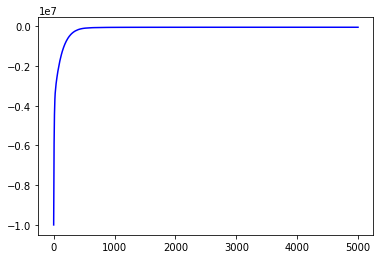

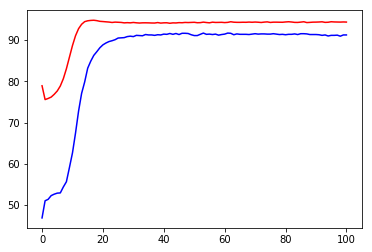

In [8]:
plt.plot(range(max_iter),sample_loss_his,'b-')
plt.show()
plt.plot(range(max_iter//print_every+1),accuracy_train_his,'r-')
plt.plot(range(max_iter//print_every+1),accuracy_val_his,'b-')
plt.show()

In [9]:
print(gamma_u)
print(gamma_b)
def predict_y(u,b):
    print(sigmoid(np.inner(gamma_u[u,:],gamma_b[b,:])))
    return sigmoid(np.inner(gamma_u[u,:],gamma_b[b,:]))>0.5

print(predict_y(user_index['U093387342'],buss_index['B408037852']))  # train +
print(predict_y(user_index['U093387342'],buss_index['B410583770']))  # train -
print(predict_y(user_index['U732361363'],buss_index['B105995104']))  # test

[[-0.0745202  -0.10263462  0.00888352 ..., -0.26618451  0.07090118
  -0.13659933]
 [ 0.16455313 -0.21634866  0.06740073 ..., -0.09269068  0.02575906
   0.10545235]
 [ 0.0309657   0.10881139  0.13402902 ...,  0.05412258  0.02863497
   0.16870759]
 ..., 
 [-0.14155444 -0.03809193  0.05777469 ...,  0.10545941  0.02863503
  -0.0512491 ]
 [-0.08136837  0.08537868 -0.05052745 ...,  0.03855905  0.11823837
  -0.11614353]
 [-0.00343077 -0.08640731 -0.17526952 ..., -0.00838396  0.11303989
  -0.05885863]]
[[-0.07175429  0.02946103 -0.07692133 ..., -0.10819634  0.09127723
  -0.06476724]
 [-0.05872598 -0.04077065  0.02233326 ..., -0.11032066 -0.03432015
   0.01952849]
 [ 0.06115277 -0.03712453 -0.04355656 ..., -0.12920506 -0.00524055
  -0.08568892]
 ..., 
 [-0.12294304  0.18899499 -0.05913857 ...,  0.0453051  -0.03797643
  -0.11730093]
 [-0.02489864  0.19047875  0.32606937 ...,  0.0144063   0.25795151
   0.05220536]
 [ 0.35019166 -0.27303258  0.1293273  ..., -0.01953249 -0.04224335
   0.07371407]]


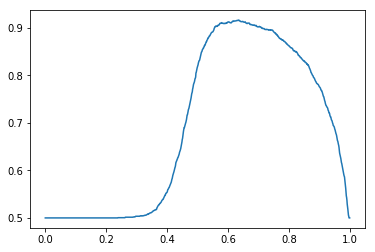

best bound = 0.633 max accuracy = 0.916


In [10]:
bound_list=np.linspace(0,1,1001)
accuracy_his=[]
max_accuracy=-1
best_bound=-1
for bound in bound_list:
    accuracy=0
    for i in range(num_val):
        predict=sigmoid(np.inner(gamma_u[ui_val[i],:],gamma_b[bi_val[i],:]))>bound
        accuracy+=1 if predict==y_val[i] else 0
    accuracy/=num_val
    if accuracy>max_accuracy:
        max_accuracy=accuracy
        best_bound=bound
    accuracy_his.append(accuracy)
plt.plot(bound_list,np.array(accuracy_his))
plt.show()
print('best bound =',best_bound,'max accuracy =',max_accuracy)

In [11]:
true_pos=0
true_neg=0
false_pos=0
false_neg=0

for i in range(num_val):
    ui=ui_val[i]
    bi=bi_val[i]
    real=y_val[i]
    
    predict=sigmoid(np.inner(gamma_u[ui,:],gamma_b[bi,:]))>best_bound
        
    if predict==1 and real==1:
        true_pos+=1
    elif predict==1 and real==0:
        false_pos+=1
    elif predict==0 and real==1:
        false_neg+=1
    elif predict==0 and real==0:
        true_neg+=1
print('accuracy =',(true_pos+true_neg)/num_val)
print('true pos =',true_pos)
print('false pos =',false_pos)
print('false neg =',false_neg)
print('true neg=',true_neg)
pp=true_pos/(true_pos+false_pos)
rr=true_pos/(true_pos+false_neg)
print('F1 =',(2.0*pp*rr)/(pp+rr))

accuracy = 0.916
true pos = 916
false pos = 84
false neg = 84
true neg= 916
F1 = 0.916


In [12]:
test_file=open('data/pairs_Visit.txt')
fo=open('data/pairs_Visit_out_4.txt','w')
fo.write('userID-businessID,prediction\n')
c1=0
c2=0
c3=0
for line in test_file:
    if line == 'userID-businessID,prediction\n':
        continue
    [u,b]=line.strip().split('-')
    if u not in user_index or b not in buss_index:
        predict=random.randint(0,1)
        fo.write('%s-%s,%d\n' %(u,b,predict))
        c1+=1
    else:
        ui=user_index[u]
        bi=buss_index[b]

        predict=sigmoid(np.inner(gamma_u[ui,:],gamma_b[bi,:]))>best_bound
                
        fo.write('%s-%s,%d\n' %(u,b,predict))
        c3+=1
fo.close()
print(c1,c2,c3)

63 0 39937
